In [1]:
# Packages 
using PyPlot, LinearAlgebra, SparseArrays, GSL, DifferentialEquations, Sundials, PyCall, LsqFit, Printf, Interpolations, DelimitedFiles, JLD2 

In [2]:
# Plotting parameters
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 15
rcParams["legend.fontsize"] = "x-large"
rcParams["axes.labelsize"] = "x-large"
rcParams["axes.titlesize"] = "x-large"
rcParams["xtick.labelsize"] = "x-large"
rcParams["ytick.labelsize"] = "x-large"
rcParams["font.sans-serif"] = "Arial"
rcParams["font.family"] = "sans-serif"
rcParams["figure.figsize"] = (6, 6);

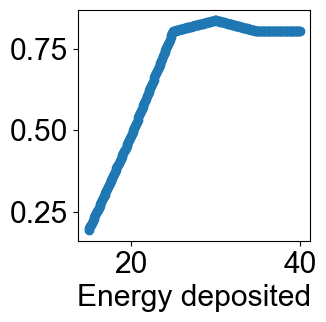

In [3]:
@load "./en_loss_data/ene_data.jld2" envals_kev ene_loss
figure(figsize=(3,3));
plot(envals_kev,ene_loss,linestyle="",marker="o"); xlabel("Energy deposited");

In [4]:
# Fitting function (energy loss) 
function ene_loss_ratio(ene_kev)
    res = zeros((length(ene_kev),))
    for i = 1:size(ene_kev,1);
        res[i] = ene_loss[argmin(abs.(ene_kev[i].-envals_kev))]
    end;
    return res
end;

In [5]:
# Reads current sweep experimental data
y_unpat_curr = readdlm("exptdata/ratio_current_data_unpat.txt",',', Float64, '\n');
y_thick4_curr = readdlm("exptdata/ratio_current_data_thick4.txt",',', Float64, '\n');
y_unpat_curr = (y_unpat_curr[:,1], y_unpat_curr[:,2], y_unpat_curr[:,3]*1e6, y_unpat_curr[:,4]);
y_thick4_curr = (y_thick4_curr[:,1], y_thick4_curr[:,2], y_thick4_curr[:,3]*1e6, y_thick4_curr[:,4]);

In [6]:
# Reads voltage sweep experimental data
y_unpat_volt = readdlm("exptdata/ratio_voltage_data_unpat.txt",',', Float64, '\n');
y_thick4_volt = readdlm("exptdata/ratio_voltage_data_thick4.txt",',', Float64, '\n');
y_unpat_volt = (y_unpat_volt[:,1], y_unpat_volt[:,2], y_unpat_volt[:,3]*1e6, y_unpat_volt[:,4]);
y_thick4_volt = (y_thick4_volt[2:end,1], y_thick4_volt[2:end,2], y_thick4_volt[2:end,3]*1e6, y_thick4_volt[2:end,4]);

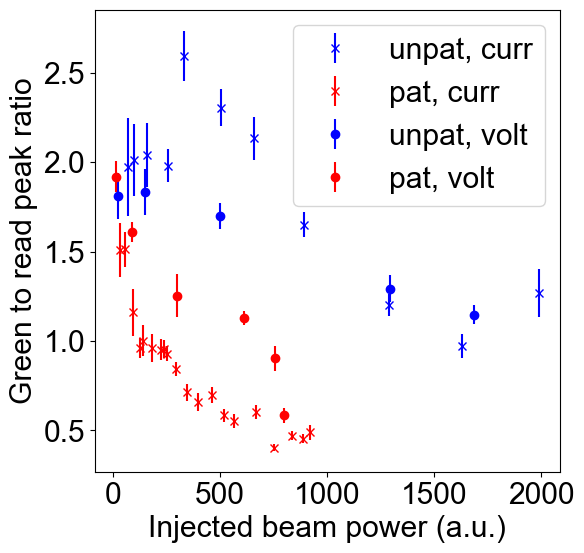

In [7]:
## Plots all experimental data on same plot 
figure()
errorbar(y_unpat_curr[4].*y_unpat_curr[3].*ene_loss_ratio(y_unpat_curr[4]), y_unpat_curr[1], yerr=y_unpat_curr[2], fmt="x", label = "unpat, curr", color = "blue");
errorbar(y_thick4_curr[4].*y_thick4_curr[3].*ene_loss_ratio(y_thick4_curr[4]), y_thick4_curr[1], yerr=y_thick4_curr[2], fmt="x", label = "pat, curr", color = "red");
errorbar(y_unpat_volt[4].*y_unpat_volt[3].*ene_loss_ratio(y_unpat_volt[4]), y_unpat_volt[1], yerr=y_unpat_volt[2], fmt="o", label = "unpat, volt", color = "blue");
errorbar(y_thick4_volt[4].*y_thick4_volt[3].*ene_loss_ratio(y_thick4_volt[4]), y_thick4_volt[1], yerr=y_thick4_volt[2], fmt="o", label = "pat, volt", color = "red");
legend()
ylabel("Green to read peak ratio");
xlabel("Injected beam power (a.u.)");

In [8]:
# Create concatenated data sets:
x_unpat = vcat(y_unpat_curr[4].*y_unpat_curr[3].*ene_loss_ratio(y_unpat_curr[4]), y_unpat_volt[4].*y_unpat_volt[3].*ene_loss_ratio(y_unpat_volt[4]));
y_unpat = vcat(y_unpat_curr[1], y_unpat_volt[1]);
yerr_unpat = vcat(y_unpat_curr[2], y_unpat_volt[2]);

x_thick4 = vcat(y_thick4_curr[4].*y_thick4_curr[3].*ene_loss_ratio(y_thick4_curr[4]), y_thick4_volt[4].*y_thick4_volt[3].*ene_loss_ratio(y_thick4_volt[4]));
y_thick4 = vcat(y_thick4_curr[1], y_thick4_volt[1]);
yerr_thick4 = vcat(y_thick4_curr[2], y_thick4_volt[2]);

# 4-level model

In [9]:
## Rate Equations Model 
# 4-level model (See SI for details)
function rate_solve(du,u,p,t)
    Γ41 = p[1];
    Γ24 = p[2];
    Γ34 = p[3];
    Γ12 = p[4];
    Γ13 = p[5];
    
    du[1] = -Γ41*u[1]*(1-u[4]) + Γ12*u[2]*(1-u[1]) + Γ13*u[3]*(1-u[1]);
    du[2] = Γ24*u[4]*(1-u[2]) - Γ12*u[2]*(1-u[1]);
    du[3] = Γ34*u[4]*(1-u[3]) - Γ13*u[3]*(1-u[1]);
    du[4] = Γ41*u[1]*(1-u[4]) - Γ24*u[4]*(1-u[2]) - Γ34*u[4]*(1-u[3]);
end;

In [10]:
# Fitting model function 
function model(x, p, sol_flag = false)
    # x is power (in mW)
    ratio1 = p[1]
    ratio4 = p[2]
    scaling = p[3]
    
    Γ24_0 = 10.
    Γ34_0 = Γ24_0*ratio4    
    Γ12_0 = Γ24_0/10.
    Γ13_0 = Γ12_0/ratio1
        
    emission_ratio = zeros(size(x,1))
    t_vec = 0.
    u_vec = 0.

    for ii = 1 : size(x,1);
        params = [scaling*x[ii], Γ24_0, Γ34_0, Γ12_0, Γ13_0];

        u0 = zeros(4);
        u0[1] = 1.0;

        tspan = (0.0, 5e2);
        prob = ODEProblem(rate_solve, u0, tspan, params)
#         sol = solve(prob, Tsit5(), reltol=1e-6, abstol=1e-6);        
#         sol = solve(prob, Rosenbrock23(), reltol=1e-6, abstol=1e-6);
        sol = solve(prob, CVODE_BDF(), reltol=1e-6, abstol=1e-6);                

        emission_ratio[ii] = (params[5]*sol.u[size(sol.t,1)][3]) / (params[4]*sol.u[size(sol.t,1)][2]);    
        t_vec = sol.t
        u_vec = sol.u
    end
    if sol_flag == false
        return emission_ratio
    else
        return emission_ratio, t_vec, u_vec
    end
end;

In [11]:
## Unpatterned fitting (use first fit to evaluate data uncertainty)
lb = [0., 0., 0.]
ub = [50., 100.,0.1]

p0_bounds = [25., 5., 1/20.]

wt = 1 ./ yerr_unpat

fit_bounds_unpat = curve_fit(model, x_unpat, y_unpat, wt, p0_bounds, lower=lb, upper=ub)

wt = 1 ./ abs.(fit_bounds_unpat.resid)

fit_bounds_unpat = curve_fit(model, x_unpat, y_unpat, wt, p0_bounds, lower=lb, upper=ub);

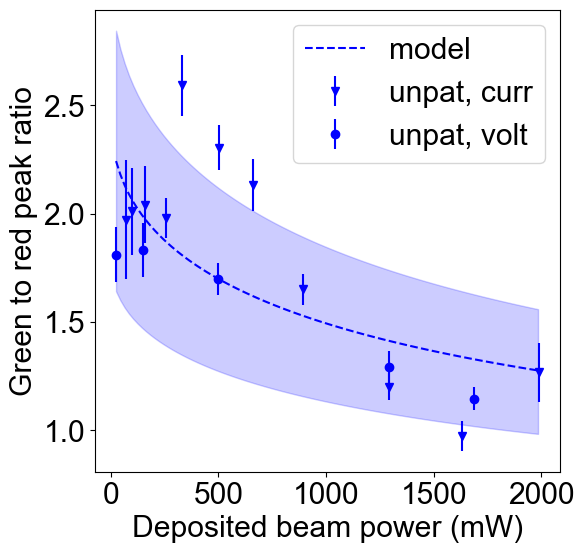

In [12]:
# Unpatterned, plot model +/- uncertainty
stdvec = [0.,stderror(fit_bounds_unpat)[2],0.]

x_unpat_plot = [minimum(x_unpat):20.0:maximum(x_unpat);]
plot(sort(x_unpat_plot), model(sort(x_unpat_plot), fit_bounds_unpat.param), "--", label = "model", color = "blue")
errorbar(y_unpat_curr[4].*y_unpat_curr[3].*ene_loss_ratio(y_unpat_curr[4]), y_unpat_curr[1], yerr=y_unpat_curr[2], fmt="v", label = "unpat, curr", color = "blue");
errorbar(y_unpat_volt[4].*y_unpat_volt[3].*ene_loss_ratio(y_unpat_volt[4]), y_unpat_volt[1], yerr=y_unpat_volt[2], fmt="o", label = "unpat, volt", color = "blue");
l = model(sort(x_unpat_plot), fit_bounds_unpat.param.-stdvec)
u = model(sort(x_unpat_plot), fit_bounds_unpat.param.+stdvec)
fill_between(sort(x_unpat_plot), l, u, alpha = 0.2, color = "blue")
legend()
xlabel("Deposited beam power (mW)")
ylabel("Green to red peak ratio");

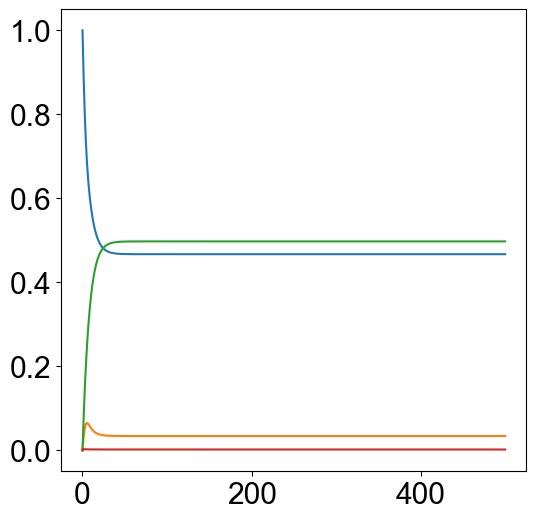

In [13]:
# Check time convergence of solver 
x_test = x_unpat[1]
_, t_test, u_test = model(x_test, fit_bounds_unpat.param, true)
plot(t_test, u_test);

# Comparison of different methods (unpatterned)

In [14]:
function evaluate_method(fit, title)
    p1, p2, p3 = fit.param
    margin_of_error = margin_error(fit)
    confidence_intervals = confidence_interval(fit)
    std_error = stderror(fit)
    print(title, " \n")    
    @printf("Γ24 = 10., Γ34 = Γ24*%.2e, Γ12 = Γ24 / 10. and Γ13 = Γ12 / %.2e Γ14 = %.2e * current (μA) \n", p2, p1, p3)
    @printf("fit parameters: %.2e, %.2e, %.2e \n", p1, p2, p3)
    print("error: \n")
    map(x -> @printf("%.2e  ",x), std_error)
    print("\n error (%): \n")    
    map(x -> @printf("%.2e  ",x), std_error./fit.param*100)    
    print("\n \n")        
end;
evaluate_method(fit_bounds_unpat, "Experimental uncertainty")

Experimental uncertainty 
Γ24 = 10., Γ34 = Γ24*2.45e+00, Γ12 = Γ24 / 10. and Γ13 = Γ12 / 1.15e+01 Γ14 = 4.44e-05 * current (μA) 
fit parameters: 1.15e+01, 2.45e+00, 4.44e-05 
error: 
1.23e+02  6.68e-01  6.25e-04  
 error (%): 
1.07e+03  2.72e+01  1.41e+03  
 


# Patterned data

In [15]:
# Patterned data fit 
p_unpat = fit_bounds_unpat.param # Take the one that has the lowest uncertainty

lb = [0., 0., 0.]
ub = [2000., 10.,1.]

p0_bounds = [p_unpat[1], p_unpat[2], p_unpat[3]]

wt = 1 ./ yerr_thick4

fit_bounds_thick4_00 = curve_fit(model, x_thick4, y_thick4, wt, p0_bounds, lower=lb, upper=ub)

wt = abs.(1 ./ fit_bounds_thick4_00.resid)
fit_bounds_thick4_00 = curve_fit(model, x_thick4, y_thick4, wt, p0_bounds, lower=lb, upper=ub);

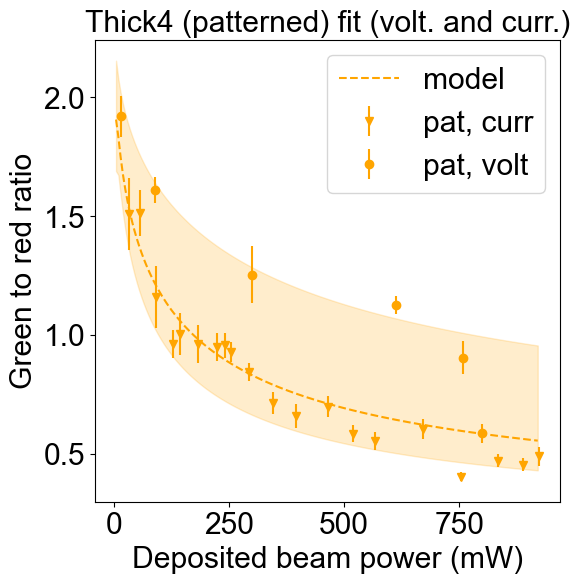

In [16]:
# Patterned data, plot model +/- uncertainty
stdvec = [stderror(fit_bounds_thick4_00)[1],0,0]

xdata_thick4_plot = [minimum(x_thick4)-10:5:maximum(x_thick4);]
figure()
plot(sort(xdata_thick4_plot), model(sort(xdata_thick4_plot), fit_bounds_thick4_00.param), "--", label = "model", color = "orange")
l = model(sort(xdata_thick4_plot), abs.(fit_bounds_thick4_00.param.-stdvec))
u = model(sort(xdata_thick4_plot), abs.(fit_bounds_thick4_00.param.+stdvec))
fill_between(sort(xdata_thick4_plot), l, u, alpha = 0.2, color = "orange")
errorbar(y_thick4_curr[4].*y_thick4_curr[3].*ene_loss_ratio(y_thick4_curr[4]), y_thick4_curr[1], yerr=y_thick4_curr[2], fmt="v", label = "pat, curr", color = "orange");
errorbar(y_thick4_volt[4].*y_thick4_volt[3].*ene_loss_ratio(y_thick4_volt[4]), y_thick4_volt[1], yerr=y_thick4_volt[2], fmt="o", label = "pat, volt", color = "orange");
xlabel("Deposited beam power (mW)")
ylabel("Green to red ratio")
title("Thick4 (patterned) fit (volt. and curr.)")
legend();

In [17]:
evaluate_method(fit_bounds_thick4_00, "Experimental uncertainty, unclamped")

Experimental uncertainty, unclamped 
Γ24 = 10., Γ34 = Γ24*2.37e+00, Γ12 = Γ24 / 10. and Γ13 = Γ12 / 4.08e+01 Γ14 = 2.47e-04 * current (μA) 
fit parameters: 4.08e+01, 2.37e+00, 2.47e-04 
error: 
2.91e+01  1.40e+00  4.54e-04  
 error (%): 
7.12e+01  5.93e+01  1.83e+02  
 


In [18]:
function fit_comparison(fit_unpat, fit_pat)
    p1_thick4, p2_thick4, p3_thick4 = fit_pat.param
    p1_unpat, p2_unpat, p3_unpat = fit_unpat.param
    enhancement = p1_thick4/p1_unpat
    current_scaling_ratio = p3_thick4/p3_unpat
    @printf("Patterned to unpatterned Γ12 / Γ13 enhancement = %.2e \n", enhancement)
    @printf("Patterned to unpatterned current scaling ratio = %.2e", current_scaling_ratio)        
    print("\n \n")            
end;
# Analysis of the fits:
fit_unpat = fit_bounds_unpat
evaluate_method(fit_bounds_thick4_00, "Experimental uncertainty, unclamped (Tsit5)")
fit_comparison(fit_unpat, fit_bounds_thick4_00)

Experimental uncertainty, unclamped (Tsit5) 
Γ24 = 10., Γ34 = Γ24*2.37e+00, Γ12 = Γ24 / 10. and Γ13 = Γ12 / 4.08e+01 Γ14 = 2.47e-04 * current (μA) 
fit parameters: 4.08e+01, 2.37e+00, 2.47e-04 
error: 
2.91e+01  1.40e+00  4.54e-04  
 error (%): 
7.12e+01  5.93e+01  1.83e+02  
 
Patterned to unpatterned Γ12 / Γ13 enhancement = 3.56e+00 
Patterned to unpatterned current scaling ratio = 5.57e+00
 
